In [1]:
import tensorflow as tf

In [2]:
import pandas as pd
import os
import numpy as np
from sklearn.utils import class_weight
from keras_preprocessing import image as im
tf.random.set_seed(
    5
)

# Loading data

In [3]:
def load_data(image_path, annotations_path):
    df = pd.read_csv(annotations_path)
    df = df[~df['human_sentiment'].isna()]
    in_folder = os.listdir(image_path)
    df.loc[df['image_name'].isin(in_folder), 'image_name'] = \
    df.loc[df['image_name'].isin(in_folder), 'image_name'].apply(lambda x: os.path.join(image_path,x))
    images = []
    for image_name in df['image_name'].values:
        images.append(np.array(im.load_img(image_name, target_size=(224,224))))
    images = np.array(images)
    images = images/255
    annotations = df['annotation'].str.lower().values
    return images, annotations

In [4]:
images, annotations = load_data("../../../../images/", '../../../../emo-at-cap.csv')

# Processing of data

In [5]:
import nltk

In [6]:
tokenizer = nltk.tokenize.WordPunctTokenizer()

In [7]:
tokenized = [tokenizer.tokenize(i) for i in annotations]

In [8]:
unique_tokens, unique_counts = np.unique(np.hstack(tokenized), return_counts=True)

In [9]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(np.hstack(tokenized)), np.hstack(tokenized))

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=["'" ',' '-' ... 'youth' 'исходный' 'текст'], y=['the' 'man' 'is' ... 'with' 'some' 'clothes'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [10]:
frequency = sorted(list(zip(unique_tokens, unique_counts)), key = lambda x: x[1])[::-1][:50]

In [11]:
frequency

[('the', 3261),
 ('is', 2031),
 ('man', 1905),
 ('and', 1536),
 ('woman', 1361),
 ('are', 1036),
 ('a', 963),
 ('to', 891),
 ('looks', 751),
 ('happy', 705),
 ('with', 547),
 ('something', 480),
 ('men', 478),
 ('of', 463),
 ('two', 408),
 ('other', 361),
 ('people', 343),
 ('couple', 334),
 (',', 330),
 ('in', 278),
 ('look', 270),
 ('because', 265),
 ('they', 256),
 ('about', 247),
 ('on', 246),
 ('at', 192),
 ('trying', 190),
 ('serious', 189),
 ('women', 184),
 ('each', 179),
 ('together', 176),
 ('by', 175),
 ('having', 171),
 ('flirting', 165),
 ('he', 155),
 ('smiling', 151),
 ('arguing', 141),
 ('angry', 140),
 ('scared', 138),
 ('worried', 137),
 ('hugging', 135),
 ('surprised', 134),
 ('calm', 133),
 ('company', 131),
 ('her', 129),
 ('group', 123),
 ('for', 121),
 ('she', 117),
 ('looking', 117),
 ('his', 115)]

In [12]:
len(unique_tokens)

2162

In [13]:
pad_token = '<PAD>'
start_token = '<S>'
end_token = '<E>'

In [14]:
vocab = dict(zip(unique_tokens,list(range(3,len(unique_tokens)+3))))
vocab[pad_token] = 0
vocab[start_token] = 1
vocab[end_token] = 2

In [15]:
inverse_vocab = dict([(v,k) for k,v in vocab.items()])

In [16]:
def padd(sentences, pad_token, start_token, end_token, maxlen=10):
    padded_sentences = []
    for i in sentences:
        sentence = [start_token] + i + [end_token]
        if len(sentence)>=maxlen+2:
            sentence = sentence[:maxlen+2]
        else:
            sentence = sentence+[pad_token for i in range(maxlen+2-len(sentence))]
        padded_sentences.append(sentence)
    return padded_sentences

In [17]:
padded_sentences = padd(tokenized, pad_token, start_token, end_token, maxlen=10)

In [18]:
np.mean([len(i) for i in padded_sentences])

12.0

In [19]:
indexed = list(map(lambda x: [vocab[i] for i in x],padded_sentences))

In [20]:
images.shape

(3840, 224, 224, 3)

In [21]:
len(class_weights)

2162

In [22]:
class_weights = list(class_weights)
class_weights.insert(0, 1)
class_weights.insert(1, 1)
class_weights.insert(2, 1)

In [23]:
len(class_weights), len(vocab)

(2165, 2165)

In [24]:
class_weights[:4]

[1, 1, 1, 0.21013259327782918]

In [25]:
class_weights = np.array(class_weights)

In [26]:
class_weights.shape

(2165,)

# Model with transfer learning

In [27]:
def calc_size(x, f, s, padding='same'):
    p = 2 if padding=='same' else 1
    return (x-f+2)/s+1

### Convolutional model

In [28]:
import tensorflow.keras.applications as apps


In [57]:
class ConvEncoder(tf.keras.Model):
    def __init__(self, trainable=False):
        super(ConvEncoder, self).__init__()
        #loading pretrained encoder
        self.encoder = tf.keras.models.load_model('encoder.h5')
        self.encoder.trainable=trainable
        
        #on top layers
        self.dense1 = tf.keras.layers.Dense(256, activation='relu')
        
    def call(self, input):
        features = self.encoder(input)
        return self.dense1(features)

In [58]:
conv_encoder = ConvEncoder()

In [31]:
conv_res = conv_encoder(np.expand_dims(images[0],axis=0))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [32]:
conv_res

<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[1.6962149 , 0.        , 0.53316873, 0.        , 0.43491125,
        0.8931499 , 0.        , 0.02045217, 0.        , 0.        ,
        0.31248945, 0.        , 0.01587697, 0.        , 0.38497663,
        1.237012  , 0.96814924, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.9723079 , 0.        ,
        0.89542437, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.5842714 , 0.98774564,
        0.        , 1.6551225 , 0.        , 0.05566136, 0.5960938 ,
        0.25621012, 0.75202477, 0.        , 0.5637547 , 0.53507894,
        0.        , 1.8837657 , 0.        , 0.05259687, 0.        ,
        1.1698389 , 0.        , 0.        , 0.        , 1.1257693 ,
        0.24965099, 0.        , 0.36666808, 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.6295284 , 0.        ,
        0.        , 0.        , 0.9481855 , 0.        , 0.        

### LSTM model

### making w2v embeddings

In [33]:
!pip install gensim

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [34]:
import gensim.downloader as api

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [35]:
w2v_embeddings = api.load('word2vec-google-news-300')

In [36]:
def build_embeddings(vocab, word_vectors, embed_dim):
    emb_matrix = np.zeros(shape=(len(vocab)+ 1 , embed_dim), dtype='float32')
    count = 0
    for word, i in vocab.items():
        try:
            emb_matrix[i, :] = word_vectors.get_vector(word)
        except:
            count += 1
            emb_matrix[i, :] = np.random.uniform(-0.1, 0.1, embed_dim)
    print('{} words are out of vocabulary：'.format(count))
    return emb_matrix


In [37]:
w2v_embeddings = build_embeddings(vocab, w2v_embeddings, 300)

22 words are out of vocabulary：


### attention

In [38]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

### building model

In [39]:
class LSTMDecoder(tf.keras.Model):
    def __init__(self, max_tokens, units=512, embeddings=None, dim=128):
        super(LSTMDecoder, self).__init__()
        self.units = units
        self.embeddings = tf.keras.layers.Embedding(input_dim=max_tokens+1, output_dim=dim, name='embeddings',
                                                   weights=[embeddings])
        self.dropout = tf.keras.layers.SpatialDropout1D(0.2)
        self.lstm = tf.keras.layers.LSTM(units=self.units, return_state=True, return_sequences=True, name='lstm_decoder', 
                                         recurrent_dropout=0.1,recurrent_initializer='glorot_uniform')
        self.intermidiate_dense = tf.keras.layers.Dense(units=self.units, activation='relu')
        self.output_dense = tf.keras.layers.Dense(units=max_tokens)
        self.attention = BahdanauAttention(self.units)

    def call(self, input, features, hidden):
        embedded = self.dropout(self.embeddings(input))
        context_vector, attention_weights = self.attention(features, hidden)
        concated = tf.concat([tf.expand_dims(context_vector, 1), embedded], axis=-1)
        result_lstm, state_h, state_c = self.lstm(concated)
        intermidiate_dense = self.intermidiate_dense(result_lstm)
        intermidiate_dense = tf.reshape(intermidiate_dense, (-1, intermidiate_dense.shape[2]))
        logits = self.output_dense(intermidiate_dense)
        return logits, state_h, attention_weights
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [40]:
lstm_decoder = LSTMDecoder(len(inverse_vocab), 256, w2v_embeddings, dim=300)

### Training

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none',
                                                                         from_logits=True)
lr_value = 1e-4
reduction_power = 10
optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_value)
with_weights = False

In [43]:
epochs = 30
batch_size = 64
patience_epochs = 2

In [44]:
def loss_function(real, pred, loss_weights):
        mask = tf.math.logical_not(tf.math.equal(real, vocab[pad_token]))
        loss_ = loss_object(real, pred)
        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        loss_weights = tf.cast(loss_weights, dtype=loss_.dtype)
        loss_*=loss_weights
        return loss_

In [45]:
@tf.function
def train_step(image, target, lengths, optimizer):
    hidden = lstm_decoder.reset_state(batch_size=target.shape[0])

    with tf.GradientTape() as tape:
        features = conv_encoder(image)
        # Teacher forcing - feeding the target as the next input
        batched_loss = []
        for t in range(1, target.shape[1]):
            
            dec_input = tf.expand_dims(target[:, t-1], 1)
            result, hidden, _ = lstm_decoder(dec_input, features, hidden)
            weights = tf.broadcast_to(class_weights, shape=(target[:,t].shape[0], class_weights.shape[0]))
            weights = tf.gather(weights, target[:,t],axis=1, batch_dims=1)
            batched_loss.append(loss_function(target[:, t], result, weights))
        batched_loss = tf.reshape(tf.stack(batched_loss), shape=target[:,1:].shape)
        batched_loss = tf.reduce_sum(batched_loss, axis=1)
        lengths = tf.cast(lengths, dtype=batched_loss.dtype)
        loss = tf.reduce_mean(batched_loss / lengths)

    perplexity = tf.exp(loss)

    variables = conv_encoder.trainable_variables + lstm_decoder.trainable_variables
    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return loss, perplexity

In [46]:
@tf.function
def evaluate(image, target, lengths, optimizer):
    hidden = lstm_decoder.reset_state(batch_size=target.shape[0])

    features = conv_encoder(image)
    # Teacher forcing - feeding the target as the next input
    batched_loss = []
    for t in range(1, target.shape[1]):

        dec_input = tf.expand_dims(target[:, t-1], 1)
        result, hidden, _ = lstm_decoder(dec_input, features, hidden)
        weights = tf.broadcast_to(class_weights, shape=(target[:,t].shape[0], class_weights.shape[0]))
        weights = tf.gather(weights, target[:,t],axis=1, batch_dims=1)
        batched_loss.append(loss_function(target[:, t], result, weights))
    
    batched_loss = tf.reshape(tf.stack(batched_loss), shape=target[:,1:].shape)
    batched_loss = tf.reduce_sum(batched_loss, axis=1)
    lengths = tf.cast(lengths, dtype=batched_loss.dtype)
    loss = tf.reduce_mean(batched_loss / lengths)
    perplexity = tf.exp(loss)


    return loss, perplexity

In [47]:
train_images, val_images, train_sequences, val_sequences =  train_test_split(images, indexed, test_size=0.2, random_state=10)
val_images, test_images, val_sequences, test_sequences =  train_test_split(val_images, val_sequences, test_size=0.5, random_state=10)

In [48]:
train_length = (np.array(train_sequences)!=vocab[pad_token]).sum(axis=1)-2

In [49]:
val_length = (np.array(val_sequences)!=vocab[pad_token]).sum(axis=1)-2

In [50]:
test_length = (np.array(test_sequences)!=vocab[pad_token]).sum(axis=1)-2

In [51]:
train_images = np.array(np.array_split(train_images, len(train_images)//batch_size))
test_images = np.array(np.array_split(test_images, len(test_images)//batch_size))
val_images = np.array(np.array_split(val_images, len(val_images)//batch_size))

train_sequences = np.array(np.array_split(train_sequences, len(train_sequences)//batch_size))
test_sequences = np.array(np.array_split(test_sequences, len(test_sequences)//batch_size))
val_sequences = np.array(np.array_split(val_sequences, len(val_sequences)//batch_size))

train_length = np.array(np.array_split(train_length, len(train_length)//batch_size))
test_length = np.array(np.array_split(test_length, len(test_length)//batch_size))
val_length = np.array(np.array_split(val_length, len(val_length)//batch_size))


In [52]:
train_images.shape, train_sequences.shape, train_length.shape

((48, 64, 224, 224, 3), (48, 64, 12), (48, 64))

In [53]:
!pip install tqdm

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [54]:
if not with_weights:
    class_weights = np.array([1 for i in range(len(class_weights))])

In [55]:
from tqdm import tqdm

In [56]:
train_loss = []
train_perplexity = []
val_loss = []
val_perplexity = []
overfit_epochs = 0
for epoch in range(epochs):
    epoch_train_loss = 0
    epoch_train_perplexity = 0
    epoch_val_loss = 0
    epoch_val_perplexity = 0
    for batch_train_images, batch_train_sequences, batched_train_length in tqdm(zip(train_images,train_sequences,train_length)):
        batched_train_loss, batched_train_perplexity = train_step(batch_train_images,batch_train_sequences,batched_train_length, optimizer)
        epoch_train_loss+=batched_train_loss
        epoch_train_perplexity+=batched_train_perplexity
    epoch_train_loss = epoch_train_loss/train_images.shape[0]
    epoch_train_perplexity = epoch_train_perplexity/train_images.shape[0]
    train_loss.append(epoch_train_loss)
    train_perplexity.append(epoch_train_perplexity)
    print('Finished epoch {}; Train loss : {}; Train perplexity : {}'.format(epoch,epoch_train_loss,epoch_train_perplexity))
    for batch_val_images, batch_val_sequences, batched_val_length in zip(val_images,val_sequences,val_length):
        batched_val_loss, batched_val_perplexity = evaluate(batch_val_images, batch_val_sequences, batched_val_length, optimizer)
        epoch_val_loss+=batched_val_loss
        epoch_val_perplexity+=batched_val_perplexity
    epoch_val_loss = epoch_val_loss/val_images.shape[0]
    epoch_val_perplexity = epoch_val_perplexity/val_images.shape[0]
    val_perplexity.append(epoch_val_perplexity)
    val_loss.append(epoch_val_loss)
    print('Validation loss : {}; Validation perplexity : {}'.format(epoch_val_loss,epoch_val_perplexity))
    if len(val_loss)>=2 and val_loss[-2]<val_loss[-1]:
        overfit_epochs+=1
    else:
        overfit_epochs=0
    if overfit_epochs==patience_epochs:
        lr_value/=reduction_power
        optimizer.lr.assign(lr_value)
        print('There was no improvement in validation loss for {} epochs, thus reducing learning rate'.format(patience_epochs))

0it [02:21, ?it/s]


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node Cast_23 (defined at <ipython-input-45-c6d3d2a43a9c>:18) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[ExpandDims_9/_32]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when allocating tensor with shape[64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node Cast_23 (defined at <ipython-input-45-c6d3d2a43a9c>:18) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_step_21758]

Errors may have originated from an input operation.
Input Source operations connected to node Cast_23:
 lengths (defined at <ipython-input-56-fab06f67b138>:12)

Input Source operations connected to node Cast_23:
 lengths (defined at <ipython-input-56-fab06f67b138>:12)

Function call stack:
train_step -> train_step


# Viewing and saving results

In [ ]:
df = pd.DataFrame()
model_name = 'conv_lstm_transfer_learning_w2v_autoenc_fixed_size_attention'
df['train_perplexity'] = [i.numpy() for i in train_perplexity]
df['val_perplexity'] = [i.numpy() for i in val_perplexity]
df['train_loss'] = [i.numpy() for i in train_loss]
df['val_loss'] = [i.numpy() for i in val_loss]


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
plt.figure(figsize=(15,12))
plt.title('Perplexity results')
plt.plot(df['train_perplexity'])
plt.plot(df['val_perplexity'])
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.yticks(np.arange(min(df['train_perplexity']), max(df['train_perplexity'])+100,100))
plt.legend(['Train', 'Validation']);

In [ ]:
plt.figure(figsize=(15,12))
plt.title('Loss results')
plt.plot(df['train_loss'])
plt.plot(df['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yticks(np.arange(min(df['train_loss']),max(df['train_loss']),0.2))
plt.legend(['Train', 'Validation']);

# Testing model

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
class Decoder:
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = None,
                 units:int = 256):
        self.encoder = encoder
        self.decoder = decoder
        self.max_len = max_len if max_len else 100
        self.start_token = start_token
        self.end_token = end_token
        self.units = units

    def decode(self, input):
        pass


class GreedyDecoder(Decoder):
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = 10,
                 units:int = 256
                 ):
        super().__init__(encoder,
                         decoder,
                         start_token,
                         end_token,
                         max_len,
                         units
                         )

    def decode(self, input):
        features = self.encoder(np.expand_dims(input, axis=0))
        hidden = np.zeros((1,self.units))
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = self.start_token
        res = []
        while True:
            # Sample a token
            output, hidden, _ = self.decoder(target_seq,features,hidden)
            sampled_token_index = np.argmax(tf.nn.softmax(output.numpy()))
            if len(res) > self.max_len or sampled_token_index == self.end_token:
                break

            res.append(sampled_token_index)

            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = sampled_token_index

       
        return res


In [ ]:
class BeamSearchDecoder(Decoder):
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = 10,
                 units:int = 256
                 ):
        super().__init__(encoder,
                         decoder,
                         start_token,
                         end_token,
                         max_len,
                         units
                         )

    def decode(self, input, beam_size=3):
        start = [self.start_token]
        features = self.encoder(np.expand_dims(input,axis=0))

        hidden = np.zeros((1,self.units))
        start_word = [[start, 0.0, hidden]]

        while len(start_word[0][0]) < self.max_len:
            temp = []
            for s in start_word:
                target_seq = np.array([[s[0][-1]]])
                hidden = s[-1]
                output, hidden, _ = self.decoder(target_seq, features, hidden)
                output = np.hstack(output)
                output = tf.nn.softmax(output).numpy()
                word_preds = np.argsort(output)[-beam_size:]

                for w in word_preds:
                    next_cap, prob = s[0][:], s[1]
                    next_cap.append(w)
                    prob += output[w]
                    temp.append([next_cap, prob, hidden])

            start_word = temp
            # Sorting according to the probabilities
            start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
            # Getting the top words
            start_word = start_word[-beam_size:]

        start_word = start_word[-1][0]

        final_caption = []

        for i in start_word:
            if i != self.end_token:
                final_caption.append(i)
            else:
                break
        return final_caption[1:]

In [ ]:
def predict(data, decoder, inverse_vocab,
           beam_size=None):
    if beam_size:
        result = decoder.decode(data, beam_size=beam_size)
    else:
        result = decoder.decode(data)
    return ' '.join([inverse_vocab[i] for i in result])

In [ ]:
greedy_decoder = GreedyDecoder(conv_encoder, lstm_decoder, vocab[start_token], vocab[end_token],
             max_len=10, units=256)

In [ ]:
beam_decoder = BeamSearchDecoder(conv_encoder, lstm_decoder, vocab[start_token], vocab[end_token],
             max_len=10, units=256)

In [ ]:
images.shape

In [ ]:
idx = np.random.choice(range(len(images)))
sample = images[idx]

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(sample)
plt.grid([])
plt.axis('off');
print(annotations[idx])

In [ ]:
predict(sample, greedy_decoder, inverse_vocab)

In [ ]:
predict(sample, beam_decoder, inverse_vocab, beam_size=3)

In [ ]:
predict(sample, beam_decoder, inverse_vocab, beam_size=5)

In [ ]:
predict(sample, beam_decoder, inverse_vocab, beam_size=7)

In [ ]:
predict(sample, beam_decoder, inverse_vocab, beam_size=10)

# Blue score calculation

In [ ]:
from nltk.translate.bleu_score import sentence_bleu


### making predictions on test dataset with beam_size of 5

In [ ]:
test_predictions = []
for batch in tqdm(test_images):
    for image in batch:
        result = predict(image, beam_decoder, inverse_vocab, beam_size=5)
        test_predictions.append(result)

In [ ]:
test_predictions = [i.split(' ') for i in test_predictions]

In [ ]:
reshaped_sequences = test_sequences.reshape(test_sequences.shape[0]*test_sequences.shape[1],-1)

In [ ]:
test_sentences = []
for i in reshaped_sequences:
    tmp = []
    for word in i:
        if word!=0 and word!=1 and word!=2:
            tmp.append(inverse_vocab[word])
    test_sentences.append(tmp)

In [ ]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction))
print('Overall bleu score on test data : {}'.format(np.mean(bleu_score)))
df['overall_bleu'] = np.mean(bleu_score)*100

In [ ]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(1,)))
print('Bleu score on test data for n-gram = 1 : {}'.format(np.mean(bleu_score)))
df['n1_bleu'] = np.mean(bleu_score)*100

In [ ]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0,1)))
print('Bleu score on test data for n-gram = 2 : {}'.format(np.mean(bleu_score)))
df['n2_bleu'] = np.mean(bleu_score)*100

In [ ]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0,0,1)))
print('Bleu score on test data for n-gram = 3 : {}'.format(np.mean(bleu_score)))
df['n3_bleu'] = np.mean(bleu_score)*100

In [ ]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0,0,0,1)))
print('Bleu score on test data for n-gram = 4 : {}'.format(np.mean(bleu_score)))
df['n4_bleu'] = np.mean(bleu_score)*100

In [ ]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0.25,0.25,0.25,0.25)))
print('Acuumulated bleu score on test data for n-gram = 4 : {}'.format(np.mean(bleu_score)))
df['acc_bleu'] = np.mean(bleu_score)*100

In [ ]:
df.head()

In [ ]:
df.to_csv('{}_logs.csv'.format(model_name),index=False)

In [151]:
conv_encoder.save_weights('{}_encoder.h5'.format(model_name))

In [152]:
lstm_decoder.save_weights('{}_decoder.h5'.format(model_name))

# Predictions on own data

In [133]:
img = np.array(im.load_img('hospital-birth.jpg', target_size=(224,224)))/255

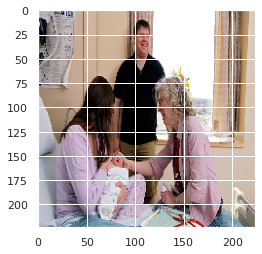

In [134]:
plt.imshow(img)

In [135]:
predict(img, greedy_decoder, inverse_vocab)

'the man is happy man is happy man is happy man'

In [136]:
predict(img, beam_decoder, inverse_vocab, beam_size=3)

'the man is happy man is happy man is'

In [137]:
predict(img, beam_decoder, inverse_vocab, beam_size=5)

'the man is happy man is happy man is'

In [138]:
predict(img, beam_decoder, inverse_vocab, beam_size=7)

'the man is happy man is happy man is'

In [139]:
predict(img, beam_decoder, inverse_vocab, beam_size=10)

'the man is happy man is happy man is'